In [9]:
import pandas as pd
import plotly.express as px
import numpy as npa

# --- load your full dataset first ---
df = pd.read_csv("clash_retention_clean.csv")   

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1924352 entries, 0 to 1924351
Data columns (total 28 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   battleTime               object 
 1   gameMode.id              int64  
 2   playerId                 object 
 3   StartingTrophies         int64  
 4   TrophyChange             int64  
 5   PlayerCrowns             int64  
 6   PlayerCards.list         object 
 7   PlayerTotalCard.level    int64  
 8   PlayerElixir.average     float64
 9   AverageStartingTrophies  float64
 10  arena                    object 
 11  next_battleTime          object 
 12  time_until_next          float64
 13  hours_until_next         float64
 14  days_until_next          float64
 15  return_bucket            object 
 16  result                   int64  
 17  prev_result              int64  
 18  win_streak               int64  
 19  loss_streak              int64  
 20  prev_trophies            float64
 21  trophy_c

/var/folders/1p/7_j5xrp575b6k3xgb5rbcclh0000gn/T/ipykernel_52769/2959131155.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



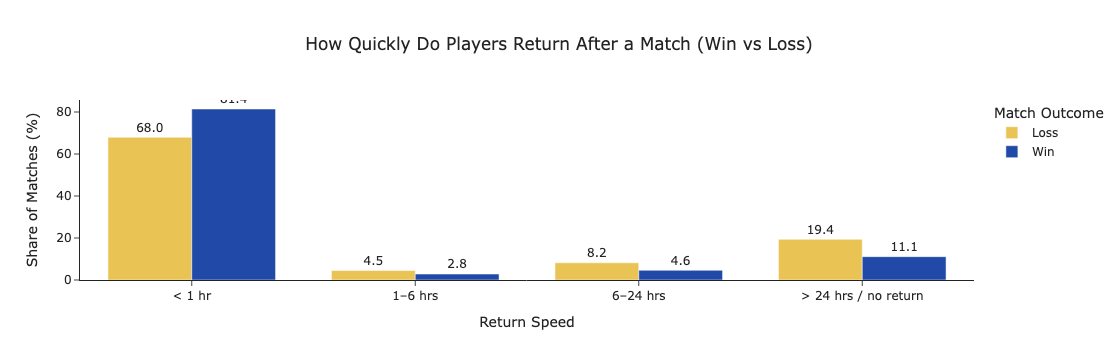

In [17]:
import pandas as pd
import plotly.express as px
import numpy as np

# -------------------------------------------------------------------
# Load and prepare data
# -------------------------------------------------------------------
df = pd.read_csv("clash_retention_clean.csv")

# Create return-speed buckets
bins = [0, 1, 6, 24, np.inf]
labels = ["< 1 hr", "1–6 hrs", "6–24 hrs", "> 24 hrs / no return"]
df["return_bucket"] = pd.cut(df["hours_until_next"], bins=bins, labels=labels)

# Map result → readable outcome label
df["outcome"] = df["result"].map({1: "Win", 0: "Loss"})

# Keep only rows with needed fields
plot_df = df.dropna(subset=["return_bucket", "outcome"]).copy()

# -------------------------------------------------------------------
# Compute % share of each return bucket by match outcome
# -------------------------------------------------------------------
counts = (
    plot_df.groupby(["outcome", "return_bucket"])
    .size()
    .reset_index(name="match_count")
)

# Normalize to percentages within each outcome group
counts["percent"] = (
    counts["match_count"] /
    counts.groupby("outcome")["match_count"].transform("sum") * 100
)

# Bucket order for consistent plotting
bucket_order = ["< 1 hr", "1–6 hrs", "6–24 hrs", "> 24 hrs / no return"]

# -------------------------------------------------------------------
# Build visualization
# -------------------------------------------------------------------
fig1 = px.bar(
    counts,
    x="return_bucket",
    y="percent",
    color="outcome",
    text="percent",
    barmode="group",
    category_orders={"return_bucket": bucket_order},
    labels={
        "return_bucket": "Return Speed",
        "percent": "Share of Matches (%)",
        "outcome": "Match Outcome"
    },
    title="How Quickly Do Players Return After a Match (Win vs Loss)",
    color_discrete_map={
        "Win": "#2149A7",
        "Loss": "#E9C455"
    }
)

# -------------------------------------------------------------------
# Formatting for slide-ready clarity
# -------------------------------------------------------------------
fig1.update_traces(
    texttemplate="%{text:.1f}",
    textposition="outside"
)

fig1.update_layout(
    template="simple_white",
    yaxis_tickformat=".0f",
    uniformtext_minsize=10,
    uniformtext_mode="hide",
    bargap=0.25,
    title_x=0.5
)

fig1.show()

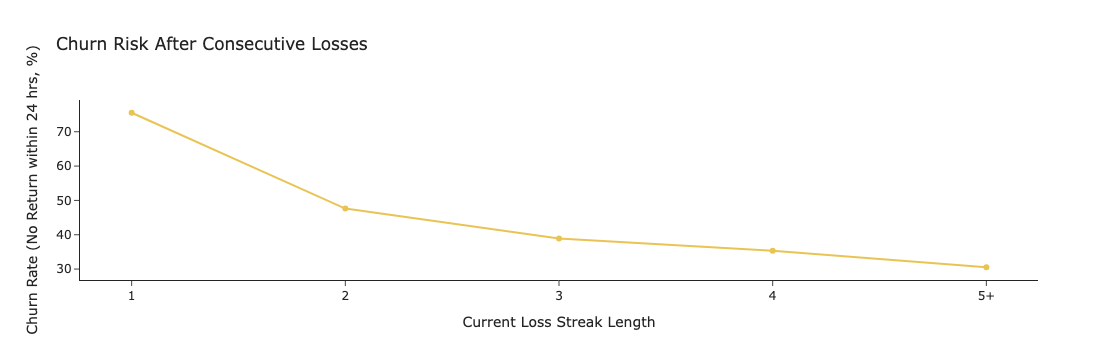

In [7]:
import pandas as pd
import numpy as np
import plotly.express as px

df = pd.read_csv("clash_retention_clean.csv")

# assume loss_streak column exists and hours_until_next is in hours
# filter to matches that ended in a loss
loss_df = df[df["result"] == 0].copy()

# define churn: did not return within 24 hours (or never returned)
loss_df["churn_24h"] = (
    (loss_df["hours_until_next"].isna()) |
    (loss_df["hours_until_next"] > 24)
)

# cap loss_streak at 5+
loss_df["loss_streak_bucket"] = loss_df["loss_streak"].clip(upper=5)
loss_df["loss_streak_bucket"] = loss_df["loss_streak_bucket"].astype(int)
loss_df["loss_streak_bucket"] = loss_df["loss_streak_bucket"].astype(str)
loss_df.loc[loss_df["loss_streak"] >= 5, "loss_streak_bucket"] = "5+"

# aggregate churn rate by streak bucket
churn = (
    loss_df
    .groupby("loss_streak_bucket")["churn_24h"]
    .mean()
    .reset_index()
)

# ensure logical ordering of buckets
order = ["0", "1", "2", "3", "4", "5+"]
churn["loss_streak_bucket"] = pd.Categorical(
    churn["loss_streak_bucket"],
    categories=order,
    ordered=True
)
churn = churn.sort_values("loss_streak_bucket")

# convert to percentage
churn["churn_rate_pct"] = churn["churn_24h"] * 100

fig2 = px.line(
    churn,
    x="loss_streak_bucket",
    y="churn_rate_pct",
    markers=True,
    labels={
        "loss_streak_bucket": "Current Loss Streak Length",
        "churn_rate_pct": "Churn Rate (No Return within 24 hrs, %)"
    },
    title="Churn Risk After Consecutive Losses",
    color_discrete_sequence=["#E9C455"]   # tilt / danger color
)

fig2.update_layout(
    template="simple_white",
    yaxis_tickformat=".0f"
)

fig2.show()

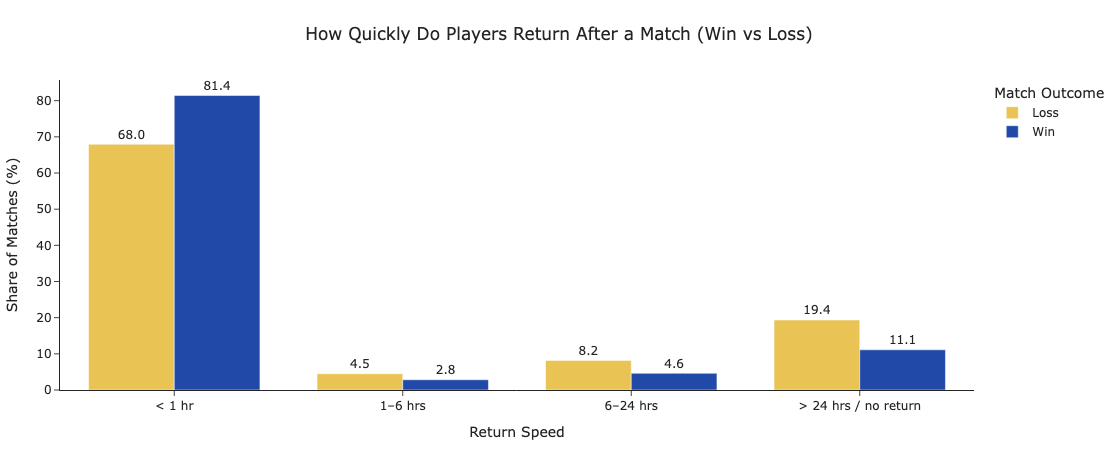

In [19]:
fig1.update_layout(
    width=900,          # <--- reduce width (try 700–900)
    height=450,         # optional: slightly shorter
    template="simple_white",
    yaxis_tickformat=".0f",
    uniformtext_minsize=10,
    uniformtext_mode="hide",
    bargap=0.25,
    title_x=0.5,
    margin=dict(l=40, r=40, t=80, b=40)   # cleaner spacing
)


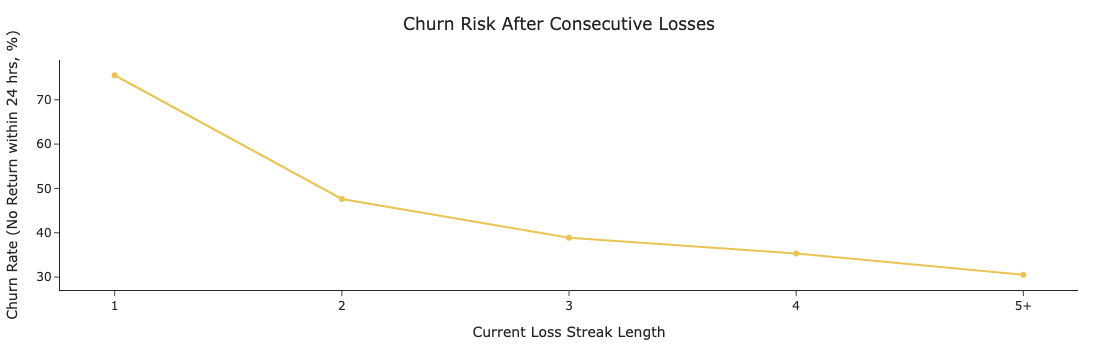

In [23]:
import pandas as pd
import numpy as np
import plotly.express as px

df = pd.read_csv("clash_retention_clean.csv")

# Filter: only losses
loss_df = df[df["result"] == 0].copy()

# Define churn = did not return within 24 hours
loss_df["churn_24h"] = (
    loss_df["hours_until_next"].isna() |
    (loss_df["hours_until_next"] > 24)
)

# Bucket loss streaks (5+ combined)
loss_df["loss_streak_bucket"] = loss_df["loss_streak"].clip(upper=5)
loss_df["loss_streak_bucket"] = loss_df["loss_streak_bucket"].astype(int).astype(str)
loss_df.loc[loss_df["loss_streak"] >= 5, "loss_streak_bucket"] = "5+"

# Aggregate churn %
churn = (
    loss_df.groupby("loss_streak_bucket")["churn_24h"]
    .mean()
    .reset_index()
)

# Order buckets
order = ["0", "1", "2", "3", "4", "5+"]
churn["loss_streak_bucket"] = pd.Categorical(
    churn["loss_streak_bucket"], categories=order, ordered=True
)
churn = churn.sort_values("loss_streak_bucket")

# Convert to %
churn["churn_rate_pct"] = churn["churn_24h"] * 100

# Build plot
fig2 = px.line(
    churn,
    x="loss_streak_bucket",
    y="churn_rate_pct",
    markers=True,
    labels={
        "loss_streak_bucket": "Current Loss Streak Length",
        "churn_rate_pct": "Churn Rate (No Return within 24 hrs, %)"
    },
    title="Churn Risk After Consecutive Losses",
    color_discrete_sequence=["#E9C455"]
)

# Formatting: centered title + slide-friendly size
fig2.update_layout(
    template="simple_white",
    yaxis_tickformat=".0f",
    width=900,
    height=350,
    margin=dict(l=40, r=40, t=60, b=40),
    title_x=0.5   # <-- centers the title
)

fig2.show()
